Meu objetivo é criar um modelo de clustering que consiga reconhecer quando jogadores de futebol jogam na mesma posição ou em posições semelhantes. Por exemplo, reconhecer que Diego Alves do Flamengo e que Cássio do Corinthians exercem a mesma posição no campo, ambos são goleiros.

Junto a este pequeno projeto existe um outro notebook chamado `heatmap.ipynb` onde a parte de visualização da distribuição dos jogadores em campo é feita.

In [1]:
import pandas as pd
from plot import plotHeatmap # função criada em heatmap.ipynb nesta mesma pasta
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
import seaborn as sns

Neste projeto usarei dados de apenas 3 times: Corinthians, Flamengo e São Paulo. Cada linha dos dataframes descreve um toque na bola dado por um jogador no jogo especificado.

| Coluna | Descrição |
| --- | --- |
| X | A localização no eixo x do campo onde o toque foi feito |
| Y | A localização no eixo y do campo onde o toque foi feito |
| player | O jogador que fez o toque |
| match | O jogo em que o jogador fez o toque |

Geralmente, um jogador dá mais de 1 toque durante todo um jogo, então uma combinação `match` e `player` se repete várias vezes nos dados. Além disso, um jogador pode tocar na bola em um mesmo lugar mas em momentos diferentes, então a combinação `match`, `player`, `X` e `Y` também é normal de se repetir.

Os 3 dataframes são referentes ao Campeonato Brasileiro 2020.

In [2]:
cor = pd.read_csv('data/corinthians-heatmap-data.csv')
fla = pd.read_csv('data/flamengo-heatmap-data.csv')
sao = pd.read_csv('data/saopaulo-heatmap-data.csv')

cor.head()

,match,player,X,Y
0,Corinthians x Atlético GO,Cássio,3,53
1,Corinthians x Atlético GO,Cássio,11,63
2,Corinthians x Atlético GO,Cássio,13,19
3,Corinthians x Atlético GO,Cássio,4,50
4,Corinthians x Atlético GO,Cássio,4,50


In [3]:
# Especificando de qual time se trata cada jogador
cor['team'] = 'Corinthians'
fla['team'] = 'Flamengo'
sao['team'] = 'São Paulo'

# Unindo os 3 dataframes
teams = pd.concat([cor, fla, sao], axis=0)
teams.reset_index(drop=True, inplace=True)
teams.tail()

,match,player,X,Y,team
88687,São Paulo x Flamengo,Pablo,42,88,São Paulo
88688,São Paulo x Flamengo,Pablo,40,93,São Paulo
88689,São Paulo x Flamengo,Pablo,60,6,São Paulo
88690,São Paulo x Flamengo,Pablo,98,15,São Paulo
88691,São Paulo x Flamengo,Pablo,63,11,São Paulo


Assim como foi feito em `heatmap.ipynb`, a lógica deste projeto começa pela separação da frequência de toques do jogador em regiões. Abaixo um exemplo de como essas regiões são (o gol adversário sempre será à direita, e a parte superior sempre será o lado direito do campo, tomando o jogador em direção ao gol adversário como referencial), no gráfico, quanto mais escura é a região maior é a frequência de toques daquele jogador naquela área. Também é possível aumentar a quantidade de regiões no gráfico, assim como exibir a quantidade de toques por área, em valores totais ou normalizados, mais detalhes em `heatmap.ipynb`.

Para se ter uma pequena ideia, B. Méndez, o jogador representado no gráfico, é zagueiro, mas algumas vezes jogou como lateral direito.

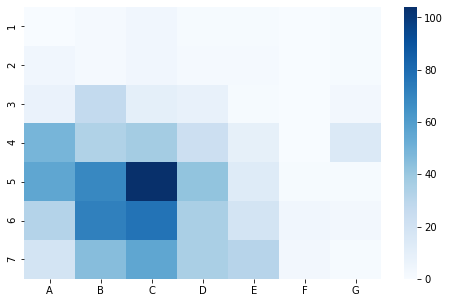

In [4]:
plotHeatmap(cor[cor['player'] == 'B. Méndez'], 7, show_labels=True)

Em seguida temos uma função que registra em qual área ocorreu cada toque de cada jogador. A função retorna um novo dataframe, contendo `match`, `player`, `team` e uma coluna para cada área da representação do campo.

Anteriormente uma combinação `match` e `player` se repetia porque um jogador dava vários toques em um jogo, agora não mais, os jogadores são agrupados por jogo, então cada linha descreve a distribuição em áreas de um jogador durante o jogo inteiro.

Falando dos parâmetros da função, `areas_by_axis` especifica quantas áreas terão na lateral de cada eixo do campo, então se `areas_by_axis` é 6, o campo inteiro é divido em $6\times6=36$ regiões. Já `normalize` normaliza a distribuição dos toques de um jogador pelas regiões de modo que a soma dos valores das áreas é igual a 1.

In [5]:
def getAreasDataframe(data, areas_by_axis=6, normalize=False):
    def findYArea():
        left = i*areas_size
        right = (i+1)*areas_size
        
        for j in range(areas_by_axis):
            down = j*areas_size
            up = (j+1)*areas_size
            
            if left <= x and x <= right   and   down <= y and y <= up:
                heatmap_data.at[index, chr(letter_code)+str(areas_by_axis-j)] += 1
                return True
        return False
    
    players = data[['match', 'player', 'team']].copy()
    
    columns = [chr(65+i) + str(j+1) for i in range(areas_by_axis) for j in range(areas_by_axis)]
    index = [i for i in range(data.shape[0])]
    areas = pd.DataFrame(index=index, columns=columns).fillna(0)
    
    heatmap_data = pd.concat([players, areas], axis=1)
    
    for index, row in data.iterrows():
        x, y = row['X'], row['Y']

        areas_size = 100/areas_by_axis
        letter_code = 64
        
        for i in range(areas_by_axis): # Para cada área no eixo X
            letter_code += 1
            if findYArea():
                break
                
    heatmap_data = heatmap_data.groupby(['match', 'player', 'team'], as_index=False).sum()
    
    if normalize:
        columns = heatmap_data.select_dtypes(exclude='object').columns
        heatmap_data[columns] = (heatmap_data[columns].transpose() / heatmap_data[columns].sum(axis=1)).transpose()
    
    return heatmap_data

In [6]:
# Obtendo a distribuição por área dos jogadores, sendo 49 áreas,
# e normalizando para que todos os valores tenham a mesma proporção

data = getAreasDataframe(teams, areas_by_axis=7, normalize=True)
data[data.columns].head()

,match,player,team,A1,A2,A3,A4,A5,A6,A7,...,F5,F6,F7,G1,G2,G3,G4,G5,G6,G7
0,Athletico-PR x Corinthians,B. Méndez,Corinthians,0.000000,0.000000,0.016393,0.098361,0.032787,0.000000,0.000000,...,0.0,0.00000,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000
1,Athletico-PR x Corinthians,Fagner,Corinthians,0.000000,0.000000,0.000000,0.000000,0.096386,0.024096,0.048193,...,0.0,0.00000,0.024096,0.0,0.0,0.00000,0.012048,0.012048,0.012048,0.108434
2,Athletico-PR x Corinthians,Gil,Corinthians,0.017544,0.052632,0.105263,0.035088,0.000000,0.000000,0.000000,...,0.0,0.00000,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000
3,Athletico-PR x Corinthians,Jô,Corinthians,0.000000,0.000000,0.000000,0.000000,0.062500,0.000000,0.000000,...,0.0,0.00000,0.000000,0.0,0.0,0.00000,0.031250,0.000000,0.000000,0.000000
4,Athletico-PR x Corinthians,L. Natel,Corinthians,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.04878,0.073171,0.0,0.0,0.02439,0.000000,0.024390,0.073171,0.048780


Interpretando um pouco do resultado, L. Natel, na linha 4, durante o jogo Athletico-PR x Corinthians não deu nenhum toque na bola em nenhuma das áreas A's, que é ali a borda mais próxima do eixo y, onde fica o goleiro. Já o Jô, linha 3, 6.25% de todos os seus toques na bola durante o mesmo jogo foram dentro da área A5.

Com os dados no formato que eu queria, eu já posso criar um modelo de clustering, no caso, usarei K-Means. O meu modelo vai criar 20 cluster, ou grupos, onde cada cluster terão jogadores que tiveram comportamento semelhantes entre si durante um jogo.

Pode ser que um mesmo jogador seja classificado de forma diferente em jogos diferentes, isso porque ele pode ter, naturalmente, jogado em outra posição, mais recuado, mais ofensivo ou mais ao lado etc.

In [7]:
areas_columns = data.columns[3:]

km = KMeans(n_clusters=20, random_state=0)

km.fit(data[areas_columns])

# Criando uma coluna para obter as classificações para cada linha
data['cluster'] = km.predict(data[areas_columns])

In [8]:
# Os clusters de cada jogador por jogo
data[['match', 'player', 'cluster']].head()

,match,player,cluster
0,Athletico-PR x Corinthians,B. Méndez,18
1,Athletico-PR x Corinthians,Fagner,2
2,Athletico-PR x Corinthians,Gil,17
3,Athletico-PR x Corinthians,Jô,4
4,Athletico-PR x Corinthians,L. Natel,11


Vemos que o cluster que o Fagner faz parte no jogo Athletico-PR x Corinthians é o 2, mas não sabemos ainda o que cada cluster significa. Para resolver isso, no caso deste projeto, podemos usar `km.cluster_centers_` para visualizar sob qual base cada linha do dataframe foi classificada.

Então abaixo temos um heatmap com a frequência média dos jogadores classificados como cluster 2, que realmente se assemelha muito ao comportamento de um lateral direito, a posição do Fagner.

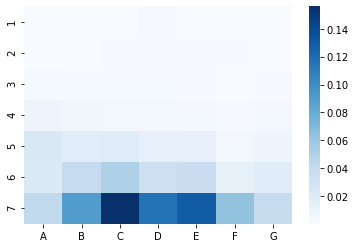

In [61]:
def plotCluster(cluster):
    n_areas = 7

    a1 = km.cluster_centers_[cluster,:]

    c2 = np.empty((n_areas, n_areas))
    
    for i in range(n_areas):
        c2[:,i] = a1[i*n_areas:(i+1)*n_areas]
    
    xlabels = [chr(65+i) for i in range(n_areas)]
    ylabels = [i+1 for i in range(n_areas)]
    sns.heatmap(c2, cmap='Blues', xticklabels=xlabels, yticklabels=ylabels);

plotCluster(2)

E a título de curiosidade também é fácil saber quais outros jogadores foram classificados no mesmo cluster que o Fagner, e quantas vezes eles foram classificados.

In [11]:
data[data['cluster'] == 2]['player'].value_counts().head()

Fagner         25
M. Isla        13
I. Vinícius    13
Juanfran        9
M. Macedo       5
Name: player, dtype: int64

Ok, o Juanfran foi classificado 9 vezes como cluster 2, mas quantos jogos o Juanfran jogou? Não podemos cravar que o cluster 2 é o cluster perfeito para o jogador, ele pode ter sido classificado 9 vezes como cluster 2 e 29 vezes como cluster 3, por tanto, o cluster 3 seria o mais ideal para defini-lo.

Para resolver isso, vamos fazer mais algumas manipulações de dados.

Irei utilizar o método One-Hot Encoder para separar a coluna `cluster` em várias outras e vou normalizar as linhas de modo que cada coluna diz a porcentagem de vezes que um jogador foi classificado em um determinado cluster. Por exemplo, podemos ver que o Reinaldo foi classificado em 73.5% dos jogos como sendo do cluster 3 e em 26.5% dos jogos como sendo do cluster 8.

In [33]:
freq_df = pd.crosstab([data['team'], data['player']], data['cluster'], normalize='index')
freq_df

cluster                        0         1         2         3         4   \
team        player                                                          
Corinthians B. Méndez    0.000000  0.000000  0.066667  0.000000  0.066667   
            Cássio       0.371429  0.000000  0.000000  0.000000  0.000000   
            D. Avelar    0.000000  0.000000  0.000000  0.000000  0.000000   
            Everaldo     0.000000  0.000000  0.000000  0.200000  0.000000   
            Fagner       0.000000  0.000000  0.781250  0.000000  0.000000   
...                           ...       ...       ...       ...       ...   
São Paulo   Reinaldo     0.000000  0.000000  0.000000  0.735294  0.000000   
            T. Tchê      0.000000  0.310345  0.034483  0.000000  0.137931   
            T. Volpi     0.473684  0.000000  0.000000  0.000000  0.000000   
            V. F. Bueno  0.000000  0.000000  0.000000  0.000000  0.095238   
            Welington    0.000000  0.000000  0.000000  1.000000  0.000000   

cluster                        5         6         7         8         9   \
team        player                                                          
Corinthians B. Méndez    0.000000  0.000000  0.000000  0.000000  0.533333   
            Cássio       0.628571  0.000000  0.000000  0.000000  0.000000   
            D. Avelar    0.000000  0.538462  0.000000  0.000000  0.000000   
            Everaldo     0.000000  0.000000  0.000000  0.200000  0.000000   
            Fagner       0.000000  0.000000  0.000000  0.000000  0.000000   
...                           ...       ...       ...       ...       ...   
São Paulo   Reinaldo     0.000000  0.000000  0.000000  0.264706  0.000000   
            T. Tchê      0.000000  0.000000  0.172414  0.000000  0.034483   
            T. Volpi     0.526316  0.000000  0.000000  0.000000  0.000000   
            V. F. Bueno  0.000000  0.000000  0.095238  0.238095  0.000000   
            Welington    0.000000  0.000000  0.000000  0.000000  0.000000   

cluster                   10      11        12        13        14   15  \
team        player                                                        
Corinthians B. Méndez    0.0  0.0000  0.000000  0.000000  0.000000  0.0   
            Cássio       0.0  0.0000  0.000000  0.000000  0.000000  0.0   
            D. Avelar    0.0  0.0000  0.000000  0.000000  0.000000  0.0   
            Everaldo     0.0  0.0000  0.000000  0.000000  0.000000  0.0   
            Fagner       0.0  0.0625  0.000000  0.000000  0.000000  0.0   
...                      ...     ...       ...       ...       ...  ...   
São Paulo   Reinaldo     0.0  0.0000  0.000000  0.000000  0.000000  0.0   
            T. Tchê      0.0  0.0000  0.000000  0.000000  0.034483  0.0   
            T. Volpi     0.0  0.0000  0.000000  0.000000  0.000000  0.0   
            V. F. Bueno  0.0  0.0000  0.047619  0.047619  0.428571  0.0   
            Welington    0.0  0.0000  0.000000  0.000000  0.000000  0.0   

cluster                        16        17        18        19  
team        player                                               
Corinthians B. Méndez    0.000000  0.000000  0.333333  0.000000  
            Cássio       0.000000  0.000000  0.000000  0.000000  
            D. Avelar    0.000000  0.461538  0.000000  0.000000  
            Everaldo     0.600000  0.000000  0.000000  0.000000  
            Fagner       0.000000  0.000000  0.000000  0.156250  
...                           ...       ...       ...       ...  
São Paulo   Reinaldo     0.000000  0.000000  0.000000  0.000000  
            T. Tchê      0.206897  0.034483  0.000000  0.034483  
            T. Volpi     0.000000  0.000000  0.000000  0.000000  
            V. F. Bueno  0.047619  0.000000  0.000000  0.000000  
            Welington    0.000000  0.000000  0.000000  0.000000  

[92 rows x 20 columns]

In [43]:
# Frequência de classificações do Cássio por cluster
freq_df.loc[('Corinthians', 'Cássio'),:].sort_values(ascending=False).head()

cluster
5     0.628571
0     0.371429
11    0.000000
18    0.000000
17    0.000000
Name: (Corinthians, Cássio), dtype: float64

In [44]:
# Frequência de classificações do Diego Alves por cluster
freq_df.loc[('Flamengo', 'D. Alves'),:].sort_values(ascending=False).head()

cluster
0     0.5
5     0.5
11    0.0
18    0.0
17    0.0
Name: (Flamengo, D. Alves), dtype: float64

Estranhamente, os goleiros Cássio, D. Alves e T. Volpi foram classificados com dois clusters diferentes, isso parece estranho porque quem joga como goleiro não varia posição, é goleiro do início ao fim do jogo e do início ao fim do campeonato.

Vamos dar uma olhada nos clusters que foram usados para os goleiros.

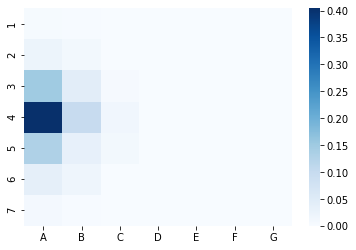

In [62]:
plotCluster(0)

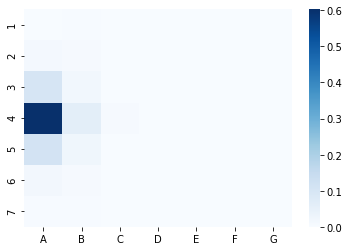

In [63]:
plotCluster(5)

Fazendo uma análise visual rápida, de fato, os clusters 0 e 5 são muito semelhantes e sem dúvidas ambos descrevem um goleiro. No entanto, a principal diferença entre eles é que o cluster 5 é mais concentrado em uma área, sendo 60% dos toques dentro de uma só região, enquanto que no cluster 0, a concentração de toques em uma região não passa de 40%.

In [45]:
# Frequência de classificações do Gerson por cluster
freq_df.loc[('Flamengo', 'Gerson'),:].sort_values(ascending=False).head()

cluster
7     0.303030
4     0.242424
13    0.121212
10    0.090909
15    0.060606
Name: (Flamengo, Gerson), dtype: float64

In [46]:
# Frequência de classificações do Daniel Alves por cluster
freq_df.loc[('São Paulo', 'D. Alves'),:].sort_values(ascending=False).head()

cluster
4     0.500000
1     0.200000
16    0.100000
7     0.100000
2     0.033333
Name: (São Paulo, D. Alves), dtype: float64

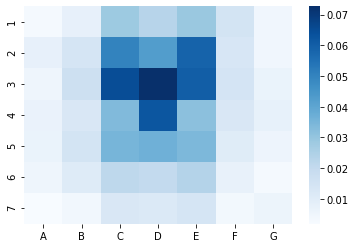

In [64]:
# Visualizando o cluster mais frequente para o Gerson do Flamengo
plotCluster(7)

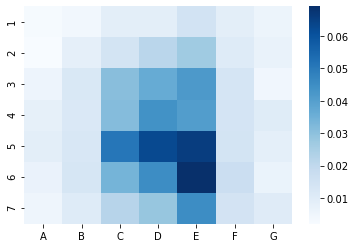

In [65]:
# Visualizando o cluster mais frequente para o Daniel Alves do São Paulo, que é também o segundo mais frequente para o Gerson
plotCluster(4)

In [77]:
# Obtendo os jogadores mais vezes classificados como do cluster 4, sendo o Pepê classificado dessa forma em 100% de seus jogos
freq_df[4].sort_values(ascending=False).head()

team         player    
Flamengo     Pepê          1.000000
São Paulo    D. Alves      0.500000
Flamengo     João Gomes    0.400000
São Paulo    Luciano       0.387097
Corinthians  Ramiro        0.333333
Name: 4, dtype: float64